In [2]:
# Import packages
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from theano.tensor.nlinalg import matrix_inverse 
from sympy import ellipse
# change default plotting
plt.rcParams.update({'font.size': 22, 'figure.figsize': (12,3)})
import warnings
warnings.filterwarnings('ignore')

demo of make_vonmises function:


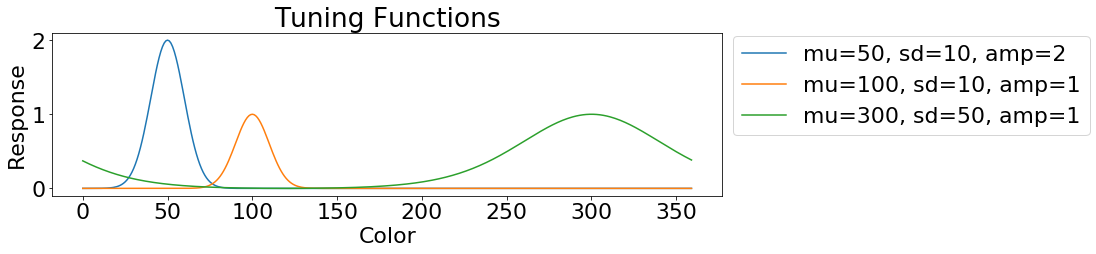

In [3]:
# Convenience functions
k2sd = lambda k : np.sqrt( -2 * np.log( sp.special.iv(1,k) / sp.special.iv(0,k) ) )

def sd2k(S):
    try:
        len(S)
    except:
        S = np.array([S])
    R = np.exp(-S**2/2)
    K = 1/(R**3 - 4 * R**2 + 3 * R)
    if np.any(R < 0.85):
        K[R < 0.85] = -0.4 + 1.39 * R[R < 0.85] + 0.43/(1 - R[R < 0.85])
    if np.any(R < 0.53):
        K[R < 0.53] = 2 * R[R < 0.53] + R[R < 0.53]**3 + (5 * R[R < 0.53]**5)/6
    if len(S) == 1:
        K = float(K)
    return K

def wrap360(a,b):
    try:
        len(a)
    except:
        a = np.array([a]); b= np.array([b])
    diff = np.full(len(a),np.nan)
    for k in np.arange(len(a)):
        diff[k] = b[k] - a[k]
        if diff[k] < -180:
            diff[k] = b[k] - a[k] + 360
        elif diff[k] > 180:
            diff[k] = b[k] - a[k] - 360
    return diff

def within360(x):
    try:
        len(x)
    except:
        x = np.array([x])
    x[x>359] = x[x>359]-360
    x[x>359] = x[x>359]-360
    x[x<0] = x[x<0]+360
    return x

def correct_basis(x,nchannels):
    while len(x[x>359]) > 0:
        x[x>359] = x[x>359]-360
    while len(x[x<0]) > 0:
        x[x<0] = x[x<0]+360
    x = np.sort(x)
    if x[0] >= 360/nchannels/2:
        x = x-(360/nchannels)
    if x[0] < -360/nchannels/2:
        x = x+(360/nchannels)
    return x

nchannels=6
def make_vonmises(xx,mu,sd,amp=1):
    res = np.exp(sd2k(np.deg2rad(sd))*np.cos(np.deg2rad(xx-mu)))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd))))
    res[np.isnan(res)] = 0 # if requesting a stick function (very small sd), return a stick function
    if np.all(res==0):
        res[int(np.floor(mu))] = amp
    norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
    return norm_res * amp

def make_vonmises_iter(xx,mu,sd,amp=np.ones(nchannels)/nchannels):
    res1 = np.full( (360,len(mu)) , np.nan)
    for i in range(len(mu)):
        res = np.exp(sd2k(np.deg2rad(sd[i]))*np.cos(np.deg2rad(xx-mu[i])))/(2*np.pi*sp.special.i0(sd2k(np.deg2rad(sd[i]))))
        res[np.isnan(res)] = 0 
        if np.all(res==0):
            res[int(np.floor(mu[i]))] = amp[i]
        norm_res = (res - np.min(res)) / (np.max(res) - np.min(res)) 
        res1[:,i] = norm_res * amp[i]
    return res1
    
print('demo of make_vonmises function:')
plt.plot(make_vonmises(np.linspace(0,359,360),50,10,[2]),label="mu=50, sd=10, amp=2")
plt.plot(make_vonmises(np.linspace(0,359,360),100,10,[1]),label="mu=100, sd=10, amp=1")
plt.plot(make_vonmises(np.linspace(0,359,360),300,50,[1]),label="mu=300, sd=50, amp=1")
plt.xlabel('Color')
plt.ylabel('Response')
plt.legend(bbox_to_anchor=(1, 1.05))
plt.title("Tuning Functions")
plt.show()

# function to automate voxel simulation:
def sim_vox(plotting=0):
    # Simulate voxels
    trial_features = within360(np.random.permutation(np.arange(ntrials)))
    trial_by_vox = np.full((ntrials,nvoxels),np.nan); 
    for vox in np.arange(nvoxels):
        vox_tuning = make_vonmises( 
            np.linspace(0,359,360),
            vox_mu[vox],
            vox_sd[vox],
            vox_amp[vox])
        for trial in np.arange(ntrials):
            vox_w_noise = vox_tuning[trial_features[trial]] + (np.random.rand()*vox_noise)
            trial_by_vox[trial,vox] = np.sum(vox_w_noise)
    if plotting:
        with plt.rc_context(rc={'font.size': 14, 'figure.figsize': (12,1)}):
            plt.hist(vox_mu,bins=30)
            plt.ylabel('Count')
            plt.title("Each voxel's maximal color preference")
            plt.show()
            plt.hist(vox_amp,bins=30)
            plt.ylabel('Count')
            plt.title("Each voxels's amplitude if maximal stimulus")
            plt.show()
            plt.hist(vox_sd,bins=30)
            plt.ticklabel_format(useOffset=False)
            plt.ylabel('Count')
            plt.title("Each voxel's sd of tuning function")
            plt.show()
    return trial_by_vox, np.array(trial_features)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '84986' (I am process '39731')


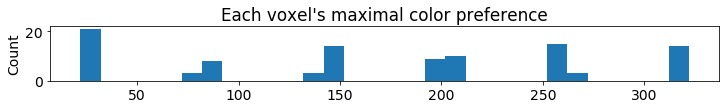

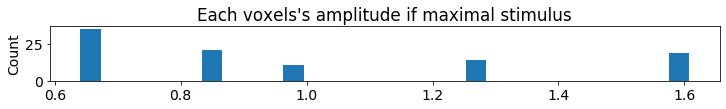

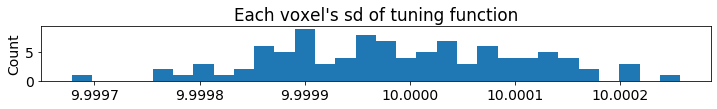

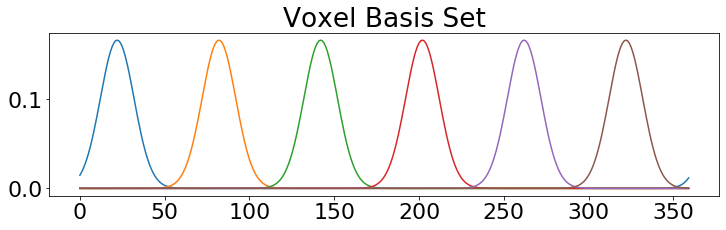

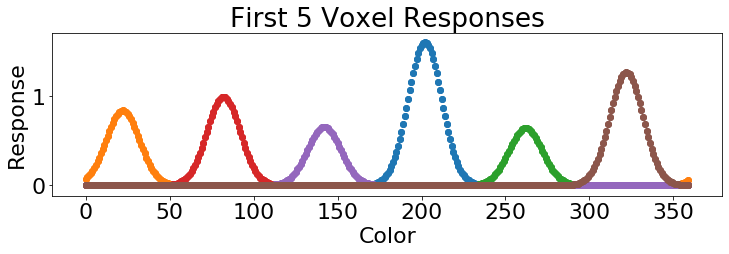

In [4]:
ntrials = 720
nvoxels = 100
vox_mu_sd = .0001
vox_sd_mu = 10
vox_sd_sd = .0001
vox_noise = .0001 # introduce noise for every voxel
feature_space = np.linspace(0,359,360) # full range of our continuous feature (here 360 degrees in color wheel)

nchannels = 6
vox_nchannels = 6
vox_mu_basis = np.linspace(0,360-(360//vox_nchannels),vox_nchannels)+22 # ground truth voxel receptive fields
basis_points = vox_mu_basis
vox_amp_basis = np.ones(vox_nchannels) # amplitude for given features

# randomize the amplitudes of the vox basis set
y_amp = pm.Dirichlet.dist(a=np.ones(nchannels)/nchannels)
vox_amp_basis = np.mean(y_amp.random(size=25),axis=0) * nchannels

y_mu = pm.NormalMixture.dist(w=np.ones(vox_nchannels)/vox_nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(vox_nchannels)*vox_mu_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

vox_amp=np.full(nvoxels,np.nan)
for vox in np.arange(nvoxels):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(vox_mu[vox],len(vox_mu_basis)),vox_mu_basis) ) )
    vox_amp[vox] = vox_amp_basis[closest_basis]
    
y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
vox_sd = y_sd.random(size=nvoxels)
channel_sd = np.ones(nchannels)*np.mean(vox_sd)

trial_by_vox, trial_features = sim_vox(plotting=1)

basis_set = make_vonmises_iter(feature_space, correct_basis(basis_points,nchannels), channel_sd) 

plt.plot(basis_set)
plt.title('Voxel Basis Set')
plt.show()

for vox in np.arange(nvoxels):
    if vox <= 5:
        plt.scatter(trial_features,trial_by_vox[:,vox])
plt.xlabel('Color')
plt.ylabel('Response')
plt.title('First 5 Voxel Responses')
plt.show()

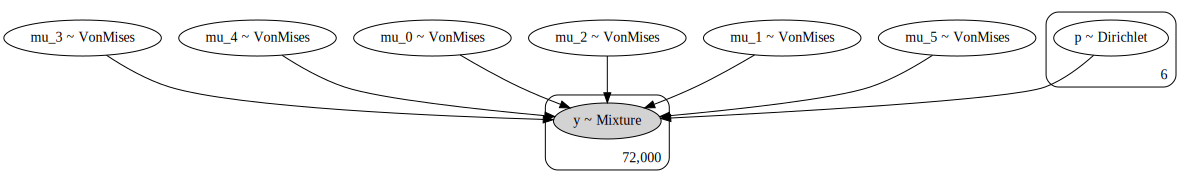

In [126]:
## Build model and sample ##

# Number of channels 
K = 6
# Number of Observations
# X = trial_by_vox.shape[1]
data = trial_by_vox.flatten()
X = len(data)
    
with pm.Model() as mymodel:
    mu = pm.floatX(vox_mu_basis) #pm.floatX(np.linspace(0,(2*np.pi)-(np.pi/K),K))    

    mus = [pm.VonMises('mu_%d' % i, 
                           mu = mu[i],
                           kappa = 33) 
               for i in range(K)]
    
#     sd = pm.Gamma('sd', alpha=2, beta=10)
    
    # Prior over component weights
    p = pm.Dirichlet('p', a=np.array([1.]*K))

#     # Individual subject level (i stands for individual-level parameter)
#     i_target_mu = pm.Normal('i_target_mu', mu=target_mu, sd=target_mu_sd, shape=nsubj) 
#     i_mem = pm.Beta('i_mem', alpha=p_memA, beta=p_memB, shape=nsubj)
#     i_tar = pm.Beta('i_tar', alpha=p_tarA, beta=p_tarB, shape=nsubj) # tar refers to conditional probability of target
#     i_target_k = pm.Gamma('i_target_k', alpha=p_target_shape, beta=p_target_rate, shape=nsubj)
#     i_swap_k = pm.Gamma('i_swap_k', alpha=p_swap_shape, beta=p_swap_rate, shape=nsubj)
    
    # Trial-level
    dists = [
#         pm.Uniform.dist(lower=np.full(ntrials,-np.pi), upper=np.full(ntrials,np.pi)), #random guessing
        pm.VonMises.dist(mu=mus[0], kappa=33),
        pm.VonMises.dist(mu=mus[1], kappa=33),
        pm.VonMises.dist(mu=mus[2], kappa=33),
        pm.VonMises.dist(mu=mus[3], kappa=33),
        pm.VonMises.dist(mu=mus[4], kappa=33),
        pm.VonMises.dist(mu=mus[5], kappa=33),
    ]
    
    y = pm.Mixture('y', w=p, comp_dists=dists, observed=data)

pm.model_to_graphviz(mymodel)

In [129]:
# modelfit = pm.fit(model=mymodel, n=25000, method='advi')

trace = modelfit.sample(1000)
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu_0,1.167672,1.663694,0.050673,-2.907245,3.138089
mu_1,0.014703,0.095250,0.002958,-0.169697,0.199241
mu_2,-2.507079,0.204169,0.007049,-2.871401,-2.099234
mu_3,0.365286,0.441129,0.013750,-0.539549,1.142420
mu_4,-1.859838,0.380688,0.012123,-2.601381,-1.133339
mu_5,0.807648,0.531920,0.014593,-0.190418,1.869127
p__0,0.010831,0.003538,0.000108,0.004865,0.017452
p__1,0.746083,0.079195,0.002665,0.591165,0.890487
p__2,0.006249,0.003337,0.000100,0.001585,0.013146
p__3,0.150725,0.055529,0.001888,0.054102,0.263286


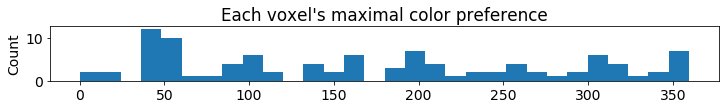

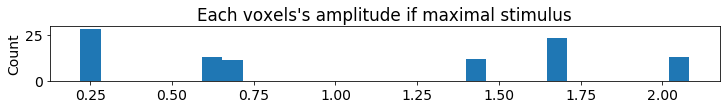

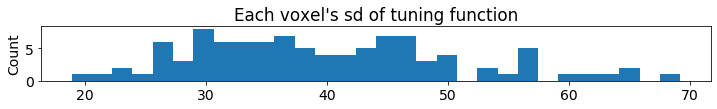

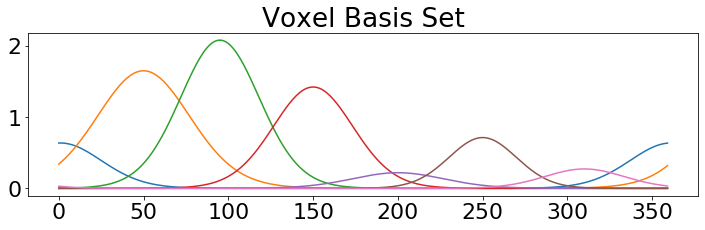

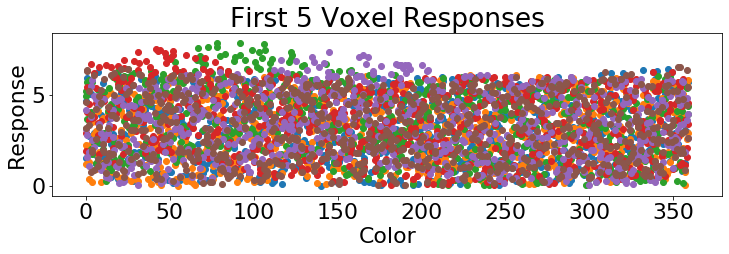

Here is another trial_by_vox example. To reiterate, the job is to create a probabilistic model that can accomodate trial_by_vox and trial_features as the only observed input. The output should be estimates of the parameters of the basis set. Specifically the mu, std, and amplitude of each channel of the basis set. Thank you very much for your help.


In [44]:
ntrials = 720
nvoxels = 100
vox_mu_sd = 10
vox_sd_mu = 40
vox_sd_sd = 10
vox_noise = 6 # introduce noise for every voxel
feature_space = np.linspace(0,359,360) # full range of our continuous feature (here 360 degrees in color wheel)

nchannels = 7
vox_nchannels = 7
vox_mu_basis = np.array([1, 50, 95, 150, 200, 250, 310]) # ground truth voxel receptive fields
basis_points = vox_mu_basis
vox_amp_basis = np.ones(vox_nchannels) # amplitude for given features

# randomize the amplitudes of the vox basis set
y_amp = pm.Dirichlet.dist(a=np.array([.1,.23,.3,.20,.03,.04,.1]))
vox_amp_basis = np.mean(y_amp.random(size=25),axis=0) * nchannels

y_mu = pm.NormalMixture.dist(w=np.ones(vox_nchannels)/vox_nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(vox_nchannels)*vox_mu_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

vox_amp=np.full(nvoxels,np.nan)
for vox in np.arange(nvoxels):
    closest_basis = np.argmin( np.abs( wrap360(np.repeat(vox_mu[vox],len(vox_mu_basis)),vox_mu_basis) ) )
    vox_amp[vox] = vox_amp_basis[closest_basis]
    
y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
vox_sd = y_sd.random(size=nvoxels)
channel_sd=[]
for c in range(nchannels):
    channel_sd.append((np.random.rand()/2+.5)*np.mean(vox_sd))

trial_by_vox, trial_features = sim_vox(plotting=1)

basis_set = make_vonmises_iter(feature_space, correct_basis(basis_points,nchannels), channel_sd, amp=vox_amp_basis) 

plt.plot(basis_set)
plt.title('Voxel Basis Set')
plt.show()

for vox in np.arange(nvoxels):
    if vox <= 5:
        plt.scatter(trial_features,trial_by_vox[:,vox])
plt.xlabel('Color')
plt.ylabel('Response')
plt.title('First 5 Voxel Responses')
plt.show()

print('Here is another trial_by_vox example. To reiterate, the job is to create a probabilistic model that can accomodate trial_by_vox and trial_features as the only observed input. The output should be estimates of the parameters of the basis set. Specifically the mu, std, and amplitude of each channel of the basis set. Thank you very much for your help.')

In [89]:
## Build model and sample ##

# Number of iterations for sampler
draws = 2000
# Number of Groups 
K = 6
# Number of Observations
X = trial_by_vox.shape[1]

# Model structure
with pm.Model() as mvgmm:
    mu = pm.floatX(np.linspace(0,(2*np.pi)-(np.pi/K),K))
    
    # Prior over component weights
#     p = pm.Dirichlet('p', a=np.array([1.]*K))
    p = pm.Beta('p', alpha=2, beta=2)
    
    # Prior over component means
    mus = [pm.MvNormal('mu_%d' % i, 
                       mu = mu[i],
                       tau = pm.floatX(1 * np.eye(X)),  #0.1, .001, 1
                       shape=(X,)) 
           for i in range(K)]
           
    # Cholesky decomposed LKJ prior over component covariance matrices
    packed_L = [pm.LKJCholeskyCov('packed_L_%d' % i,
                              n=X,
                              eta=2.,
                              sd_dist=pm.HalfCauchy.dist(10)) #1, .1, 10
                for i in range(K)]
    
    # Unpack packed_L into full array
    L = [pm.expand_packed_triangular(X, packed_L[i])
         for i in range(K)]
    
    # Convert L to sigma and tau for convenience
    sigma = [pm.Deterministic('sigma_%d' % i ,L[i].dot(L[i].T))
             for i in range(K)]
    tau = [pm.Deterministic('tau_%d' % i,matrix_inverse(sigma[i]))
           for i in range(K)]
    
    # Specify the likelihood
    mvnl = [pm.MvNormal.dist(mu=mus[i],chol=L[i])
              for i in range(K)]
    Y_obs = pm.Mixture('Y_obs',w=p, comp_dists=mvnl, observed=trial_by_vox)
    
    # Start the sampler!
#     trace = pm.sample(500,tune=500)
    modelfit = pm.fit(25000, method='advi')

# display(pm.summary(trace))
pm.summary(modelfit.sample(1000))

INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
Average Loss = 2.1136e+05: 100%|██████████| 25000/25000 [11:18<00:00, 36.85it/s]
Finished [100%]: Average Loss = 2.1136e+05
INFO (theano.gof.compilelock): Refreshing lock /Users/scotti.5/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock


,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu_0__0,0.088079,0.157812,0.004929,-0.206905,0.411684
mu_0__1,0.061547,0.134885,0.003998,-0.183191,0.346238
mu_0__2,0.045036,0.136479,0.004039,-0.218410,0.325898
mu_0__3,0.078625,0.156982,0.005327,-0.241491,0.380690
mu_0__4,0.044188,0.153976,0.004738,-0.267142,0.334806
...,...,...,...,...,...
tau_5__99_95,0.004805,0.342412,0.009915,-0.757005,0.560358
tau_5__99_96,-0.002535,0.294335,0.008857,-0.651863,0.597814
tau_5__99_97,0.018300,0.344614,0.010207,-0.611575,0.609947
tau_5__99_98,-0.015434,0.374526,0.010402,-0.559487,0.742915


In [ ]:
## Plot traces
pm.traceplot(trace, varnames = ['Sigma_Channel_7','Sigma_Channel_6','Sigma_Channel_5','Sigma_Channel_4',
                                'Sigma_Channel_3','Sigma_Channel_2','Sigma_Channel_1','mu_Channel_7','mu_Channel_6',
                                'mu_Channel_5', 'mu_Channel_4', 'mu_Channel_3','mu_Channel_2','mu_Channel_1', 'p'])
plt.show() 